## Authentication

In [1]:
!pip install -q liboidcagent requests xmltodict

In [2]:
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=36000 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

In [3]:
import requests
import xmltodict
r = requests.post("https://minio.cloud.infn.it",
                  data={
                      'Action':
                      "AssumeRoleWithWebIdentity",
                      'Version': "2011-06-15",
                      'WebIdentityToken': token,
                      'DurationSeconds': 9000
                  },
                  verify=False)

#print(r.status_code, r.reason)
tree = xmltodict.parse(r.content)

credentials = dict(tree['AssumeRoleWithWebIdentityResponse']
                    ['AssumeRoleWithWebIdentityResult']['Credentials'])

/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'minio.cloud.infn.it'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


## Get BigDL packages

In [56]:
%%bash
wget -q https://repo1.maven.org/maven2/com/intel/analytics/bigdl/dist-spark-3.0.0-scala-2.12.10-all/0.12.1/dist-spark-3.0.0-scala-2.12.10-all-0.12.1-dist.zip
mkdir bigdl
unzip dist-spark-3.0.0-scala-2.12.10-all-0.12.1-dist.zip -d bigdl_test

Archive:  dist-spark-3.0.0-scala-2.12.10-all-0.12.1-dist.zip
   creating: bigdl_test/bin/
  inflating: bigdl_test/bin/spark-submit-with-bigdl.sh  
  inflating: bigdl_test/bin/export_tf_checkpoint.py  
  inflating: bigdl_test/bin/requirements.txt  
  inflating: bigdl_test/bin/download.sh  
  inflating: bigdl_test/bin/dump_tf_graph.py  
  inflating: bigdl_test/bin/run.example.sh  
  inflating: bigdl_test/bin/spark-shell-with-bigdl.sh  
  inflating: bigdl_test/bin/img_class.lst  
  inflating: bigdl_test/bin/pyspark-with-bigdl.sh  
  inflating: bigdl_test/bin/jupyter-with-bigdl.sh  
  inflating: bigdl_test/bin/python_package.sh  
  inflating: bigdl_test/bin/classes.lst  
  inflating: bigdl_test/bin/flickr.urls  
   creating: bigdl_test/lib/
 extracting: bigdl_test/lib/bigdl-SPARK_3.0-0.12.1-jar-with-dependencies.jar  
 extracting: bigdl_test/lib/bigdl-0.12.1-python-api.zip  
   creating: bigdl_test/conf/
  inflating: bigdl_test/conf/spark-bigdl.conf  


## Create Spark session

In [4]:
from pyspark.sql import SparkSession

bigdl_jar = "/home/jovyan/SWAN_projects/bigdl/lib/bigdl-SPARK_3.0-0.12.1-jar-with-dependencies.jar"
bigdl_python_api = "/home/jovyan/SWAN_projects/bigdl/lib/bigdl-0.12.1-python-api.zip"

spark = SparkSession.builder \
        .appName("HLFClassifier") \
        .master("k8s://https://kubernetes:443") \
        .config("spark.kubernetes.container.image", "dodasts/spark:v3.0.1") \
        .config("spark.driver.memory","2g") \
        .config("spark.executor.memory", "2g") \
        .config("spark.executor.cores", "2") \
        .config("spark.cores.max", "4") \
        .config("spark.executor.instances", "2") \
        .config("spark.dynamicAllocation.enabled","false") \
        .config("spark.shuffle.reduceLocality.enabled","false") \
        .config("spark.shuffle.blockTransferService","nio") \
        .config("spark.scheduler.minRegisteredResourcesRatio","1.0") \
        .config("spark.speculation","false") \
        .config("spark.eventLog.enabled","false") \
        .config("spark.jars",bigdl_jar) \
        .config("spark.submit.pyFiles",bigdl_python_api) \
        .config("spark.hadoop.fs.s3a.endpoint", "https://minio.cloud.infn.it") \
        .config("spark.hadoop.fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider") \
        .config("spark.hadoop.fs.s3a.access.key", credentials["AccessKeyId"]) \
        .config("spark.hadoop.fs.s3a.secret.key", credentials["SecretAccessKey"]) \
        .config("spark.hadoop.fs.s3a.session.token", credentials["SessionToken"]) \
        .config("spark.hadoop.fs.s3a.path.style.access","true") \
        .config("spark.hadoop.fs.s3a.fast.upload", "true") \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.committer.name", "directory") \
        .getOrCreate()

In [5]:
spark

Before continuing, make sure that all the executors have been created. This can be seen from the k8s dashboard.

In [6]:
sc = spark.sparkContext
sc.addPyFile(bigdl_python_api)

In [7]:
# test if everything is working as expected..
sc.parallelize([1,2,3]).count()

3

# Load train and test datasets

In [8]:
train_df = spark.read.parquet("s3a://scratch/mmiglior/train_part0.parquet")
test_df = spark.read.parquet("s3a://scratch/mmiglior/test_part0.parquet")

train_df.printSchema()

root
 |-- HLF_input: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- encoded_label: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [9]:
# take a sample from the datasets
train_df = train_df.sample(0.1)
test_df = test_df.sample(0.01)

# trigger the operation and check the number of train/test samples
print(f"Train samples: {train_df.count()}")
print(f"Test samples: {test_df.count()}")

Train samples: 85631
Test samples: 8598


# Model definition

In [10]:
# Start BigDL
from bigdl.util.common import init_engine
init_engine()

In [11]:
from bigdl.nn.layer import Linear, ReLU, SoftMax, Model, Sequential

model = Sequential()
model.add(Linear(14,50))
model.add(ReLU())
model.add(Linear(50,20))
model.add(ReLU())
model.add(Linear(20,10))
model.add(ReLU())
model.add(Linear(10,3))
model.add(SoftMax())

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSoftMax


# Create train and validation RDD

We need now to create an RDD of Sample, a tuple of the form (features, label). The two elements of this touple should be numpy arrays.

In [12]:
from bigdl.util.common import Sample
import numpy as np

trainRDD = train_df.rdd.map(lambda row: Sample.from_ndarray(
    np.array(row.HLF_input),
    np.array(row.encoded_label)
))

testRDD = test_df.rdd.map(lambda row: Sample.from_ndarray(
    np.array(row.HLF_input),
    np.array(row.encoded_label)
))

In [13]:
# Let's have a look at one element of trainRDD
trainRDD.take(1)

[Sample: features: [JTensor: storage: [0.0000000e+00 2.6757314e-03 5.2008480e-01 5.6429402e-05 0.0000000e+00
  0.0000000e+00 1.1294992e-03 8.0102634e-01 6.4180404e-01 3.4492484e-01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape: [14], float], labels: [JTensor: storage: [1. 0. 0.], shape: [3], float]]

We can see that `Sample` is composed by the 14 high level features (`shape=[14]`) and the encoded label (`shape=[3]`).

# Create optimizer and train the model

In [14]:
# Set of hyperparameters
numEpochs = 10

# The batch used by BDL must be a multiple of numExecutors * executorCores
# Because data will be equally distibuted inside each executor

workerBatch = 128
numExecutors = int(sc._conf.get('spark.executor.instances'))
executorCores = int(sc._conf.get('spark.executor.cores'))

BDLbatch = workerBatch * numExecutors * executorCores

In [15]:
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import CategoricalCrossEntropy

optimizer = Optimizer(
        model = model,
        training_rdd = trainRDD,
        criterion = CategoricalCrossEntropy(),
        optim_method = Adam(),
        end_trigger = MaxEpoch(numEpochs),
        batch_size = BDLbatch   
)

# Optionally you can also set validation
optimizer.set_validation(
    batch_size=BDLbatch,
    val_rdd=testRDD,
    trigger=EveryEpoch(),
    val_method=[Loss(CategoricalCrossEntropy())]
)

creating: createCategoricalCrossEntropy
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer


/tmp/spark-8218e309-fe1c-4153-bbb2-3ca933f987eb/userFiles-59d5f410-fb38-4cbd-8e87-6cb118981efc/bigdl-0.12.1-python-api.zip/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.


creating: createEveryEpoch
creating: createCategoricalCrossEntropy
creating: createLoss


Let's define a directory to store logs (i.e. train and validation losses) and save models

In [16]:
# name of our application
appName = "HLFclassifier"

# Change it! 
logDir = "/home/jovyan/SWAN_projects/training_logs"

# Check if there is already an application with the same name 
# and remove it, otherwise logs will be appended to that app
import os
try:
    os.system('rm -rf '+logDir+'/'+appName)
except:
    pass

print("Saving logs to {}".format(logDir+'/'+appName))

Saving logs to /home/jovyan/SWAN_projects/training_logs/HLFclassifier


In [17]:
trainSummary = TrainSummary(log_dir=logDir,app_name=appName)
optimizer.set_train_summary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir,app_name=appName)
optimizer.set_val_summary(valSummary)

creating: createTrainSummary
creating: createValidationSummary


We are now ready to launch the training. \\

**WARNING**: During the trainign it would be better to shutdown the Toggle Spark Monitorin Display because each iteration is seen as a spark job, therefore the toggle will try to display everything causing problem to the browser.

In [18]:
%%time 
trained_model = optimizer.optimize()

CPU times: user 14.4 s, sys: 2.93 s, total: 17.3 s
Wall time: 3min 26s


# Plot loss

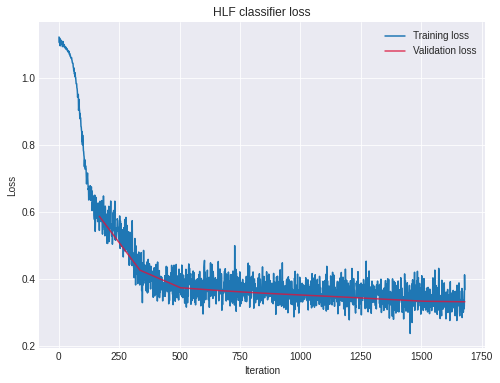

In [19]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

loss = np.array(trainSummary.read_scalar("Loss"))
val_loss = np.array(valSummary.read_scalar("Loss"))

plt.figure(figsize=(8,6))
plt.plot(loss[:,0], loss[:,1], label="Training loss")
plt.plot(val_loss[:,0], val_loss[:,1], label="Validation loss", color='crimson', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title("HLF classifier loss")
plt.show()

## Save the model

Later on it will be possible to load the model with the following command:

```{python}
model = Model.loadModel(modelPath=modelPath+'.bigdl', weightPath=modelPath+'.bin')
```

In [20]:
modelDir = logDir + '/models'
trained_model.saveModel(
            modelPath = modelDir + '/' + appName + '.bigdl',
            weightPath = modelDir + '/' + appName + '.bin',
            over_write = True
)

## Prediction

In [21]:
pred = trained_model.predict(testRDD)

In [22]:
y_pred = np.asarray(pred.collect())
y_true = np.asarray(test_df.select('encoded_label').rdd\
                    .map(lambda row: np.asarray(row.encoded_label)).collect())

In [23]:
!pip install -q sklearn

In [24]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

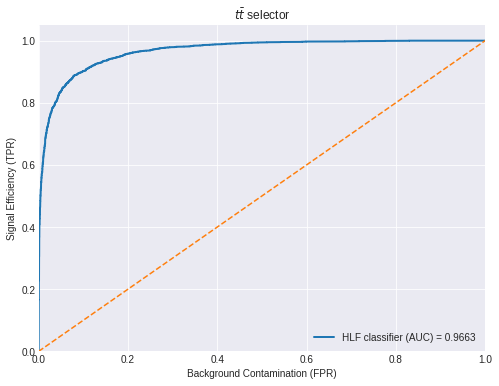

In [25]:
plt.figure(figsize=(8,6))
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title(r'$t\bar{t}$ selector')
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.8754


In [27]:
!pip install -q seaborn

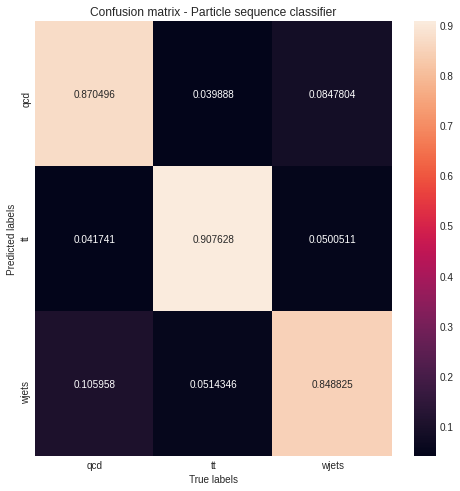

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.title('Confusion matrix - Particle sequence classifier')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()